[Based on](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

In [1]:
# LSTM for prices by month for petroleum problem with regression framing
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## Explore data

[Petrolium prices by month](https://data.world/ian/petroleum-prices-by-month) has a table with Dollars per Barrel in crude oil, bought in Brent, Europe. Monthly data from 1987 to 2016.

In [2]:
raw_data = pd.read_excel('PET_PRI_SPT_S1_M.xls')
raw_data = raw_data.ix[16:,[0,2]]
raw_data['Date'] = pd.to_datetime(raw_data['Date'])

In [3]:
raw_data

,Date,Europe Brent Spot Price FOB (Dollars per Barrel)
16,1987-05-15,18.58
17,1987-06-15,18.86
18,1987-07-15,19.86
19,1987-08-15,18.98
20,1987-09-15,18.31
21,1987-10-15,18.76
22,1987-11-15,17.78
23,1987-12-15,17.05
24,1988-01-15,16.75
25,1988-02-15,15.73


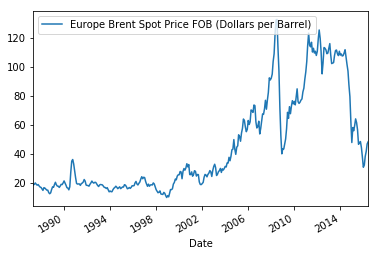

In [4]:
raw_data.plot(x = 'Date')
plt.show()

## Transform into keras data

Keep only values, and use a MinMaxScaler to normalize all data to (0,1) range. It considered good practice to rescale so sigmoid/tanh activations functions work properly.

In [6]:
dataset = raw_data.ix[:, 1:2]
dataset = dataset.astype('float32')

numpy.random.seed(7)

dataset = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset

array([[ 0.07127747],
       [ 0.07355574],
       [ 0.08169244],
       [ 0.07453214],
       [ 0.06908055],
       [ 0.07274207],
       [ 0.06476811],
       [ 0.05882831],
       [ 0.05638731],
       [ 0.04808788],
       [ 0.03995118],
       [ 0.05516681],
       [ 0.05280715],
       [ 0.04654191],
       [ 0.04141579],
       [ 0.04125306],
       [ 0.02733931],
       [ 0.02107405],
       [ 0.02603744],
       [ 0.04467047],
       [ 0.05980472],
       [ 0.05752644],
       [ 0.07225387],
       [ 0.08543532],
       [ 0.07168429],
       [ 0.06387307],
       [ 0.06346624],
       [ 0.05655004],
       [ 0.06468675],
       [ 0.07396257],
       [ 0.07249796],
       [ 0.08152971],
       [ 0.09300244],
       [ 0.0812856 ],
       [ 0.06973149],
       [ 0.05524817],
       [ 0.05313264],
       [ 0.04296176],
       [ 0.05980472],
       [ 0.14117168],
       [ 0.20406836],
       [ 0.21318144],
       [ 0.1891782 ],
       [ 0.15012205],
       [ 0.11187957],
       [ 0

## Split and build a matrix

We don't use sklearn train&test split because that would randomize our data, dealing with time series we have to preserve the order.

Afterwards, we build a matrix with the steps we want the algorithm to look back.
testX should be at the end: rank 3, dimension 3 -> 65 rows, 1 depth, 4 columns [samples, time steps, features]

The function reshapes into a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

In [19]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train

array([[ 0.07127747],
       [ 0.07355574],
       [ 0.08169244],
       [ 0.07453214],
       [ 0.06908055],
       [ 0.07274207],
       [ 0.06476811],
       [ 0.05882831],
       [ 0.05638731],
       [ 0.04808788],
       [ 0.03995118],
       [ 0.05516681],
       [ 0.05280715],
       [ 0.04654191],
       [ 0.04141579],
       [ 0.04125306],
       [ 0.02733931],
       [ 0.02107405],
       [ 0.02603744],
       [ 0.04467047],
       [ 0.05980472],
       [ 0.05752644],
       [ 0.07225387],
       [ 0.08543532],
       [ 0.07168429],
       [ 0.06387307],
       [ 0.06346624],
       [ 0.05655004],
       [ 0.06468675],
       [ 0.07396257],
       [ 0.07249796],
       [ 0.08152971],
       [ 0.09300244],
       [ 0.0812856 ],
       [ 0.06973149],
       [ 0.05524817],
       [ 0.05313264],
       [ 0.04296176],
       [ 0.05980472],
       [ 0.14117168],
       [ 0.20406836],
       [ 0.21318144],
       [ 0.1891782 ],
       [ 0.15012205],
       [ 0.11187957],
       [ 0

In [20]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX

array([[ 0.07127747,  0.07355574,  0.08169244,  0.07453214],
       [ 0.07355574,  0.08169244,  0.07453214,  0.06908055],
       [ 0.08169244,  0.07453214,  0.06908055,  0.07274207],
       ..., 
       [ 0.53986979,  0.52017897,  0.56151342,  0.6102522 ],
       [ 0.52017897,  0.56151342,  0.6102522 ,  0.53807968],
       [ 0.56151342,  0.6102522 ,  0.53807968,  0.52839708]], dtype=float32)

In [21]:
trainX.shape

(275, 4)

In [22]:
# reshape input to be [samples, time steps, features]  
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
testX.shape

(65, 1, 4)

In [23]:
trainX

array([[[ 0.07127747,  0.07355574,  0.08169244,  0.07453214]],

       [[ 0.07355574,  0.08169244,  0.07453214,  0.06908055]],

       [[ 0.08169244,  0.07453214,  0.06908055,  0.07274207]],

       ..., 
       [[ 0.53986979,  0.52017897,  0.56151342,  0.6102522 ]],

       [[ 0.52017897,  0.56151342,  0.6102522 ,  0.53807968]],

       [[ 0.56151342,  0.6102522 ,  0.53807968,  0.52839708]]], dtype=float32)

## Build the model & Make predictions

[All information about a Sequential class](https://keras.io/models/sequential/)

Measure loss with Mean Squared Error, use optimizer Adam. 1 Layer input, 4 neurons in LSTM.
Be careful not to overfit!!

Later we make predictions.

In [24]:
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=4, batch_size=1, verbose=2)

Epoch 1/4
3s - loss: 0.0106
Epoch 2/4
2s - loss: 0.0042
Epoch 3/4
2s - loss: 0.0031
Epoch 4/4
2s - loss: 0.0028


In [25]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

## How is our model?

Let's undo transformations on data to plot our training and prediction.

In [26]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [27]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.45 RMSE
Test Score: 11.76 RMSE


In [28]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [29]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

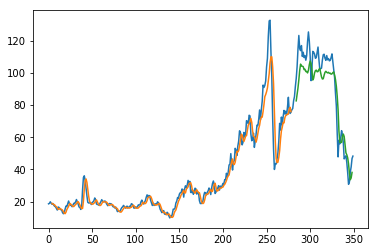

In [30]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()